In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [3]:
# Load the training data
indi_file_path = '../../Data/Clean/combined/Indianapolis_combined.csv'
train_full_df = pd.read_csv(indi_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,149771.0,2151.0,291536100.0,131097.969553,133638.666266,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,956.7,0.2,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
1,2008-05-31,151827.0,2430.0,331352084.0,132148.045670,133520.379815,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,958.9,0.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
2,2008-06-30,154789.0,2438.0,362561539.0,132930.782306,133559.343193,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,958.2,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
3,2008-07-31,157222.0,2457.0,383886935.0,133222.597102,133449.285413,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,961.2,1.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
4,2008-08-31,154119.0,2309.0,370365976.0,133037.483397,133164.069995,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,959.9,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"


In [4]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [5]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [6]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"INDIANAPOLIS, IN",1,0,0.0,"Index(['INDIANAPOLIS, IN'], dtype='object', na..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1488.97601,1,0,0.0,"Index([1488.97601], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,90.664284,1,0,0.0,"Index([90.664284], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,36.279526,1,0,0.0,"Index([36.279526], dtype='float64', name='PctB..."


In [7]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [8]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [9]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [10]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [12]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.164092,0.162498,1.000185,0.691195,0.235408,0.278630,0.161404,0.083179
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.352591,0.351997,1.070021,0.730337,0.332616,0.337014,0.356075,0.375051


Note for Indianapolis dataset
* HistGradientBoost and RidgeCV show the best performance across different transformations

In [13]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.172394,0.167234,0.955945,0.653993,0.164118,0.164350,0.168716,0.069158
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.215888,0.236328,0.885248,0.554794,0.164645,0.195669,0.236328,0.166807


Note for Indianapolis dataset
* HistGradientBoost most consistent top performer
* PowerTransformer results suspicious

In [14]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [15]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.209775,0.210217,1.000185,0.742067,0.358100,0.389496,0.207905,0.136467
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.439423,0.435191,1.100112,0.799644,0.473957,0.465144,0.434681,0.404698


Note for Indianapolis dataset
* Best Performance: RidgeCV (0.434681) and Ridge Regression (0.435191) 

In [17]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.301982,0.326072,0.976367,0.743423,0.323048,0.323918,0.319118,0.214808
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.595847,0.511914,1.000282,0.717471,0.473120,0.484253,0.533566,0.231617


Note:
* HistGradientBoost most consistent

## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [18]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [19]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"CINCINNATI, OH",1,0,0.0,"Index(['CINCINNATI, OH'], dtype='object', name..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1418.62244,1,0,0.0,"Index([1418.62244], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,93.921524,1,0,0.0,"Index([93.921524], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,43.323481,1,0,0.0,"Index([43.323481], dtype='float64', name='PctB..."


In [16]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [17]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  0.97)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.835566,52542.628661,0.334933,13.699941,0.190139,0.014971,52543.669337
numerical__PctSoldAboveList,0.249461,42475.731874,0.909832,654.693299,0.371107,0.016310,42476.368751
numerical__SaleToList,0.252069,24206.740414,0.881517,124.471900,0.365796,0.007166,24207.365444
numerical__SalesCount,0.434649,19242.287766,0.566967,5.304101,0.152700,0.151152,19243.026268
numerical__PctSoldBelowList,0.273966,17756.746850,0.954639,423.754067,0.368059,0.002804,17757.391679


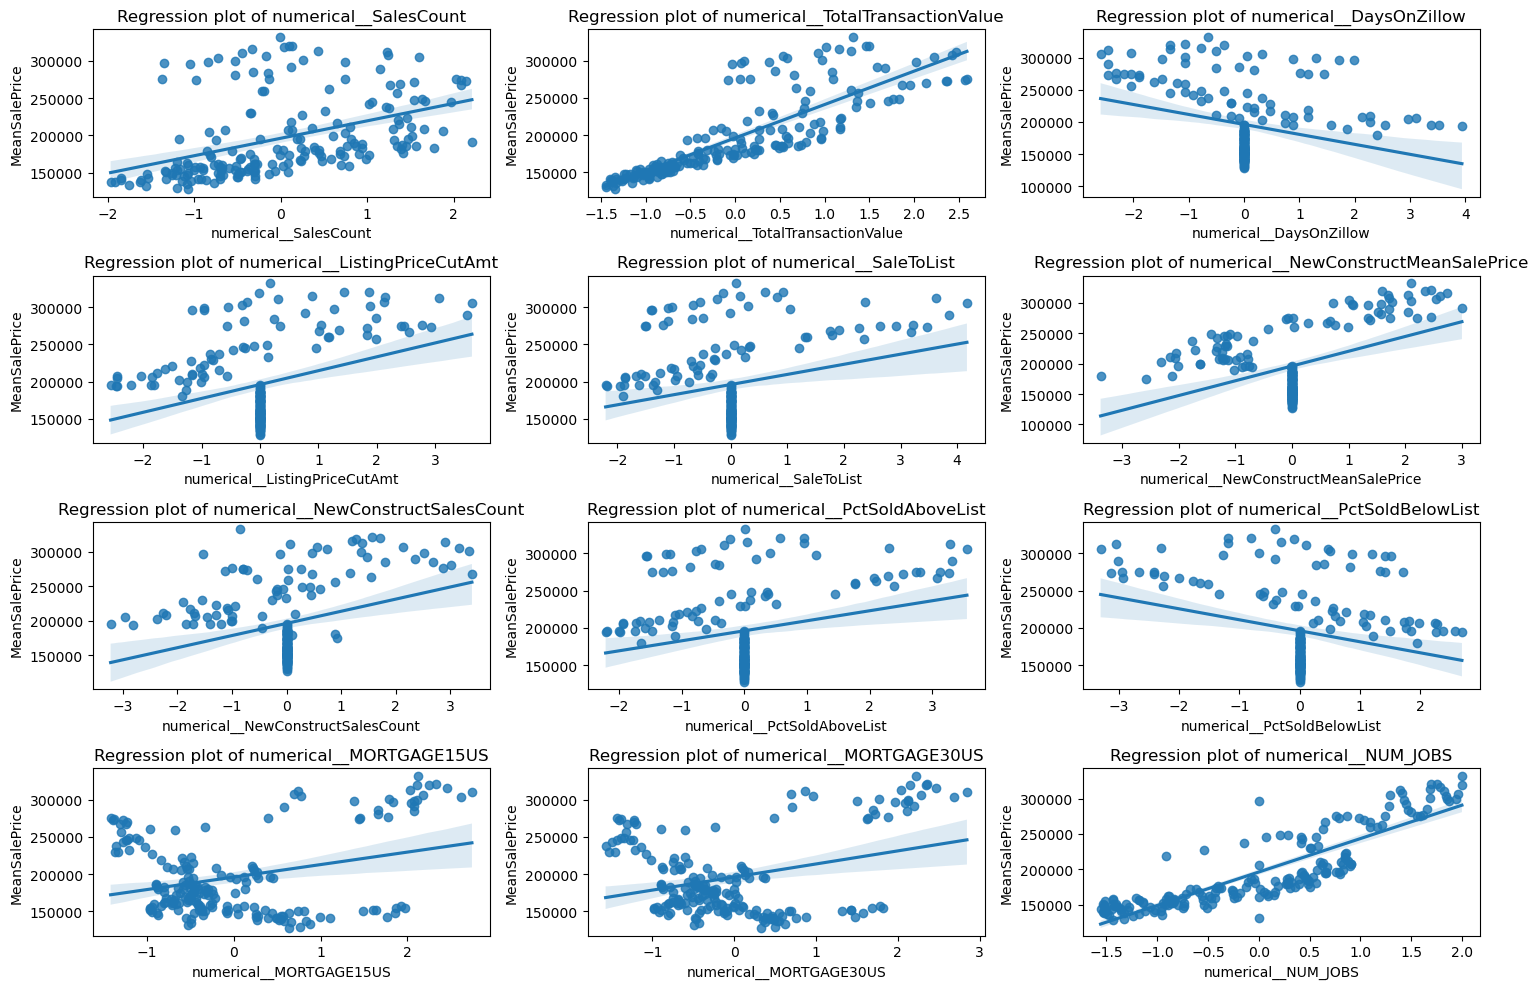

In [20]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

## Perform unsupervised feature selection

Optimal number of features: 13


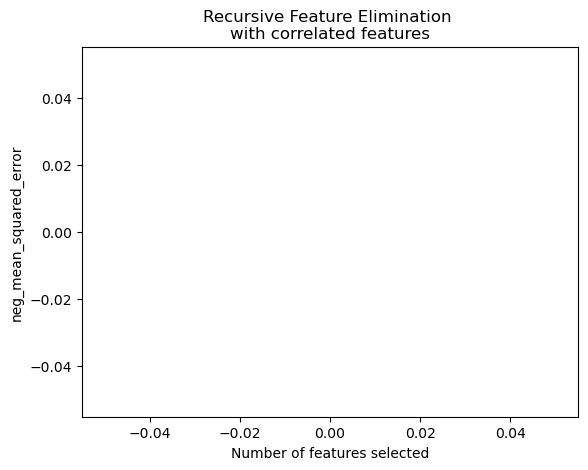

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-7.278261e+09,8.892514e+09,-9.083254e+09,-1.889284e+09,-2.602346e+08,-1.229575e+09,-2.392896e+10,True,1,SalesCount
1,-9.699146e+09,1.019216e+10,-1.409326e+10,-5.043997e+09,-3.884409e+08,-1.333517e+09,-2.763652e+10,True,1,TotalTransactionValue
2,-9.718643e+09,1.030325e+10,-1.389003e+10,-4.971069e+09,-4.089295e+08,-1.332902e+09,-2.799029e+10,True,1,MarketTempIdx
3,-6.363948e+09,7.711381e+09,-2.016746e+10,-3.572402e+08,-4.215482e+08,-1.333214e+09,-9.540275e+09,True,1,DaysToClose
4,-6.809520e+09,7.925390e+09,-2.061511e+10,-2.079047e+08,-5.171039e+08,-1.888688e+09,-1.081879e+10,True,1,DaysOnZillow


In [21]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [22]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['SalesCount' 'TotalTransactionValue' 'MarketTempIdx' 'DaysToClose'
 'DaysOnZillow' 'ListingPriceCutAmt' 'SaleToList' 'PctSoldAboveList'
 'PctSoldBelowList' 'MORTGAGE15US' 'MORTGAGE30US' 'RATE_DIFFERENCE'
 'NUM_JOBS']


Optimal number of features: 8


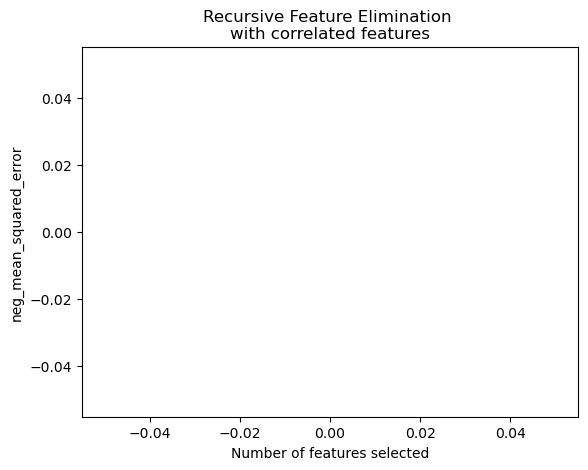

In [23]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=13))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [24]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'TotalTransactionValue' 'MarketTempIdx' 'SaleToList'
 'PctSoldAboveList' 'MORTGAGE15US' 'MORTGAGE30US' 'NUM_JOBS']


In [25]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=6)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 0.001
Selected 6 features by forward sequential featureselection in 0.641 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'DaysOnZillow', 'NewConstructSalesCount', 'NUM_JOBS', 'GROWTH_PCT']


In [39]:
# # Remove colinear features from the list of selected features
# # rfe_ridge_selected_features = [rfe_ridge_selected_features]
# rfe_ridge_selected_features = list(rfe_ridge_selected_features).remove('PctListingsPriceCut')
# rfe_ridge_selected_features

In [26]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(0, [])

## Perform final EDA with selected features and ordinal columns

In [27]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=array(['SalesCount', 'TotalTransactionValue', 'MarketTempIdx',
       'SaleToList', 'PctSoldAboveList', 'MORTGAGE15US', 'MORTGAGE30US',
       'NUM_JOBS'], dtype=object))),
                                                 ('impu...
       'DaysOnZillow', 'ListingPriceCutAmt', 'ListingPriceCutPct',
       'SaleToList', 'NewConstructMeanSalePrice', 'NewConstructSalesCount',
       'PctListingsPriceCut', 'PctSoldAboveList', 'PctSoldBelowList',
       'MORTGAGE15US', 'MORTGAGE30US', 'RATE_DIFFERENCE', 'NUM_JOBS',
       'GROWTH_PCT', 'People25PlusThousands_2019', 'PctHighSchoolDiploma_2019',
       'PctBachelorsDegree_2019'],
      dtype='object'))])

In [28]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  0.96)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.835566,51040.077983,0.252079,9.593685,0.384920,0.425542,51041.724011
numerical__MORTGAGE30US,0.325577,33891.387586,0.785971,76.382979,0.293170,0.465972,33892.472305
numerical__PctSoldAboveList,0.249461,32373.963335,0.809027,88.336928,0.437717,0.012821,32374.663334
numerical__SaleToList,0.252069,24705.116708,0.846926,80.871014,0.430317,0.029908,24705.829002
numerical__MORTGAGE15US,0.310723,20557.725868,0.867107,74.724012,0.303247,0.460128,20558.799966


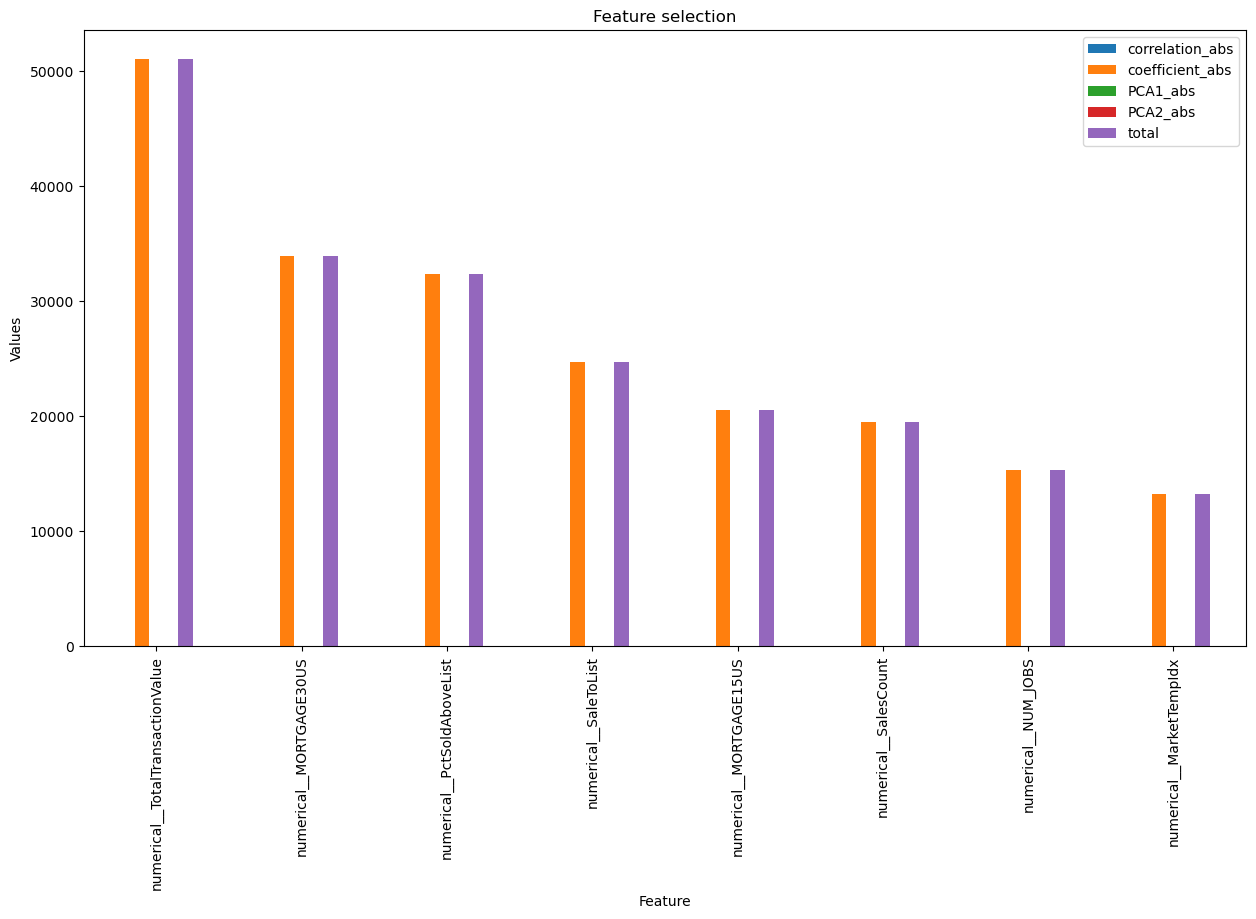

In [29]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [31]:
# Reload the data just to be safe
train_full_df = pd.read_csv(indi_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [32]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [33]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25


AttributeError: 'NoneType' object has no attribute 'fit_transform'

AttributeError: 'RegressorMultiModelEvaluator' object has no attribute 'y_test'

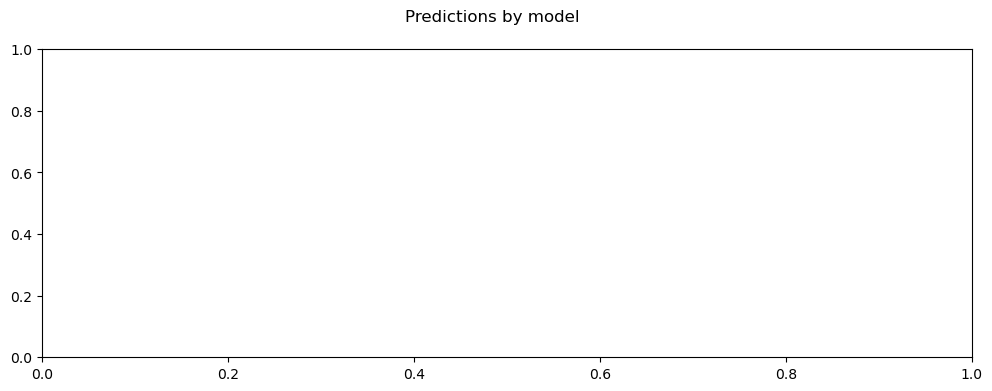

In [34]:
reg.plot_model_evaluations()

* Looks overfit to me

In [38]:
# Get the best model
reg.best_model_name

'Ridge Regression'

## Now use the best model to predict on the test data

In [39]:
# Load test data from a different city
combined_file_path = '../../Data/Clean/combined/all_cities_combined.csv'
test_full_df = pd.read_csv(combined_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [43]:
# Drop target column
combined_file_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

KeyError: "['MeanSalePrice'] not found in axis"

In [52]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([196606.75008567, 199628.83459339, 201684.87637794, 200652.66189617,
       198613.30124795, 191729.23822738, 186125.99765161, 178196.75506636,
       174843.94760544, 162387.25676913, 157376.17426905, 151286.45251209,
       154622.31205013, 161655.94872807, 175672.67480683, 181653.12194711,
       184316.01967694, 179911.72165015, 177349.01277639, 176507.67475473,
       173205.05438723, 170792.17534001, 166887.89797862, 165365.84205734,
       172394.7619298 , 179050.96870049, 182533.90984736, 183421.51819959,
       180779.08279687, 174021.4286768 , 160208.97338809, 155303.5431149 ,
       156680.42756807, 160929.87133251, 155989.5661641 , 153274.0432015 ,
       151944.39977619, 158076.85378968, 169213.1825001 , 169999.75961204,
       163865.77279975, 149984.0913178 , 149339.59270538, 148063.75151315,
       147432.32723577, 146805.18017669, 145563.55956816, 146182.27068307,
       148699.49313454, 150633.03055772, 158782.51424193, 167657.30942395,
       166124.09416407, 1

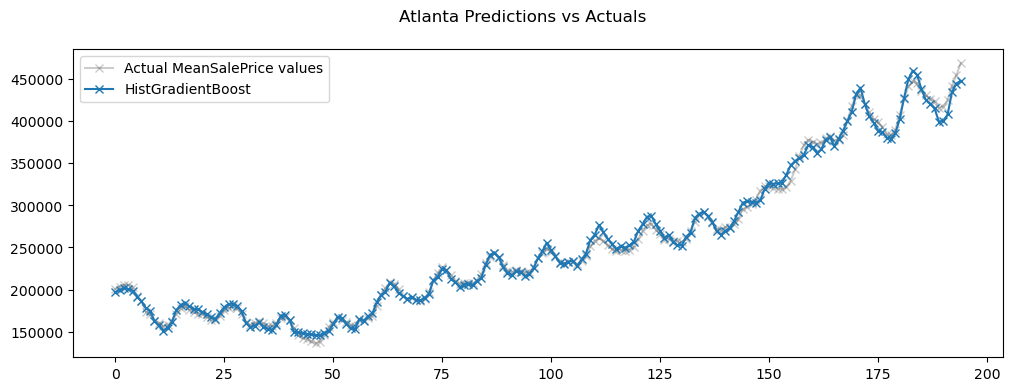

In [53]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()